<h1>ZMGSN Lista 1 - Generative Adversarial Network (GAN)</h1>

<h2>Opis zadania</h2>

W ramach zadania należy:
<ol>
<li>Zapoznać się z poniższym eksperymentem z wykorzystaniem modelu DCGAN</li>
<li>Dokonać analizy wpływu hiperparametrów eksperymentu, np. kroku uczenia, rozmiaru pakietu (ang. <i>batch size</i>), liczby epok na wyniki modelu GAN</li>
<li>Dokonać modyfikacji architektury modelu DCGAN (generatora i dyskryminatora) w celu zbadania wpływu architektury na wyniki</li>
<li>Dokonać ewaluacji innych wariantów sieci GAN, np. CycleGAN, LAPGAN, SRGAN itp. (co najmniej 2 inne modele oprócz DCGAN)</li>
<li>Opracować procedurę ewaluacji jakości działania modeli GAN, uwzględniającą różne metody wizualizacji (np. wykresy, miary, klasy), klasteryzacji, redukcji wymiarów (np. t-SNE)</li>
</ol>

Ocenie podlegać będzie jakość wykonania zadania, w tym:
<ol>
<li>Właściwe wykonanie zadań</li>
<li>Rzetelne opracowanie wyników, uwzględniające analizę jakościową i ilościową</li>
<li>Opracowanie wniosków mających na celu wyjaśnienie badanych zjawisk i uzyskanych wyników</li>
<li>Opracowanie i wyjaśnienie kodu źródłowego</li>
</ol>


<h2>Import używanych bibliotek</h2>

In [ ]:
import os

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm

<h2>Konfiguracja stylu prezentacji wykresów generowanych za pomocą biblioteki Seaborn</h2>

In [ ]:
sns.set(style='darkgrid', font_scale=1.2)

<h2>Pobranie i rozpakowanie zbioru danych</h2>

In [ ]:
# usunięcie folderów i plików tymczasowych
temp_dirs = ['cats', 'generated']

for temp_dir in temp_dirs:
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)

if os.path.exists('cats_faces.zip'):
    os.remove('cats_faces.zip')

In [ ]:
url = 'https://drive.google.com/uc?id=1n98A5XmCBWmZhXD2Hq-bz9Ms_yZl1oXl'
output = 'cats_faces.zip'
gdown.download(url, output, quiet=False)


Downloading...
From (uriginal): https://drive.google.com/uc?id=1n98A5XmCBWmZhXD2Hq-bz9Ms_yZl1oXl
From (redirected): https://drive.google.com/uc?id=1n98A5XmCBWmZhXD2Hq-bz9Ms_yZl1oXl&confirm=t&uuid=30c1c347-eb3e-4f41-a467-b24905691780
To: /home/netherwulf/Documents/Git_Repositories/zmgsn_lab/notebooks/cats_faces.zip
100%|██████████| 101M/101M [00:01<00:00, 86.0MB/s] 


'cats_faces.zip'

In [ ]:
!unzip -q ./cats_faces.zip

<h2>Przetwarzanie danych</h2>

In [ ]:
DATA_DIR = 'cats'

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR,
                       transform=tt.Compose([tt.Resize(image_size),
                                             tt.CenterCrop(image_size),
                                             tt.ToTensor(),
                                             tt.Normalize(*stats)]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    # show_images(next(iter(dl))[0], nmax)
    for images, _ in dl:
        show_images(images, nmax)
        break

<h2>Podgląd próbek danych znajdujących się w pojedynczym pakiecie</h2>

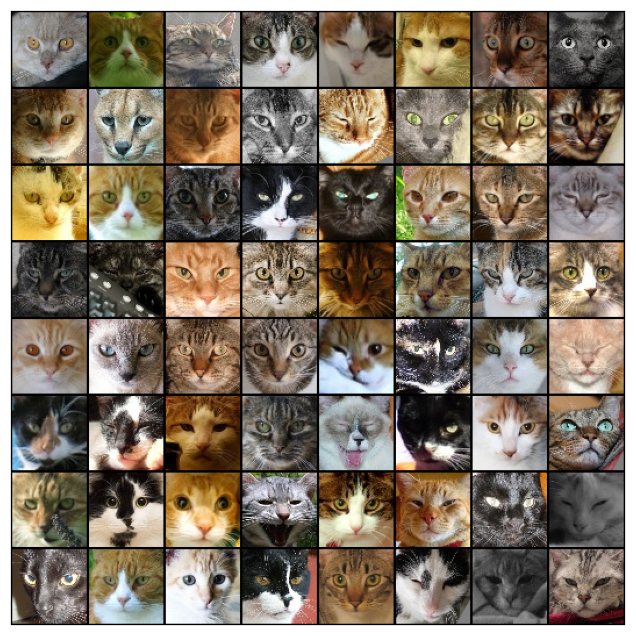

In [ ]:
show_batch(train_dl)

<h2>Implementacja wrappera dla obiektów klasy <i>Dataloader</i></h2>

In [ ]:
def to_device(data, device):
    """
    Przeniesienie wybranej instancji struktury danych
    do pamięci wybranego urządzenia
    """
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Inicjalizacja wrappera"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """
        Zwrócenie jednego pakietu danych po przeniesieniu go
        do pamięci wybranego urządzenia
        """
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """
        Zwrócenie liczby pakietów danych znajdujących się wewnątrz obiektu klasy Dataloader
        """
        return len(self.dl)

<h2>Określenie domyślnego urządzenia na podstawie sprawdzenia dostępności karty graficznej</h2>

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<h2>Wykorzystanie wrappera dla obiektów klasy <i>Dataloader</i></h2>

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

<h2>Deklaracja wymiarowości przestrzeni wektorowej danych wejściowych generatora</h2>

In [ ]:
latent_size = 128

<h2>Deklaracja podstawowej klasy generatora</h2>

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

<h2>Przeniesienie obiektu dyskryminatora do pamięci urządzenia domyślnego</h2>

In [ ]:
generator = to_device(generator, device)

<h2>Deklaracja podstawowej klasy dyskryminatora</h2>

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

<h2>Przeniesienie obiektu dyskryminatora do pamięci urządzenia domyślnego</h2>

In [ ]:
discriminator = to_device(discriminator, device)

<h2>Przygotowanie danych wejściowych dla generatora</h2>

torch.Size([128, 3, 64, 64])


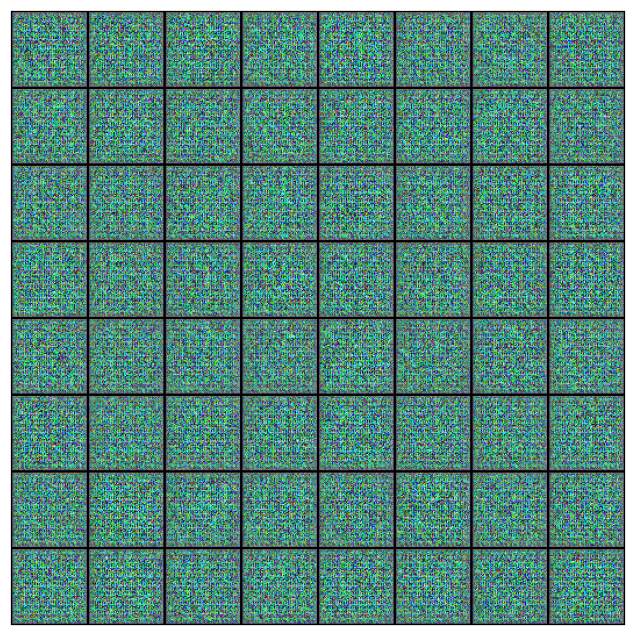

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu())

<h2>Przygotowanie katalogu na obrazy wygenerowane przez model</h2>

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

<h2>Inicjalizacja przykładowych danych wejściowych dla generatora</h2>

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

<h2>Deklaracja funkcji służącej do zapisywania wygenerowanych obrazów</h2>

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = f'generated-images-{index:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

<h2>Wizualizacja procesu uczenia</h2>

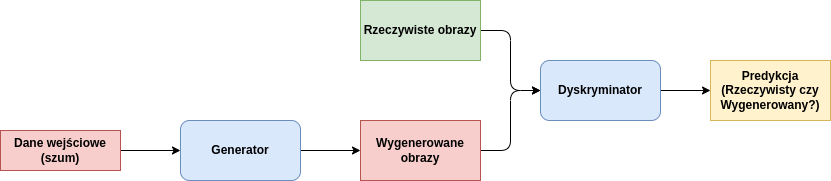

<h2>Przykładowa pętla ucząca</h2>

In [ ]:
def fit(model, train_dl, criterion, epochs, lr):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Inicjalizacja struktur danych do przechowywania wartości funkcji straty
    # oraz wyników dla rzeczywistych i wygenerowanych obrazów
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Inicjalizacja optymalizatora
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Uczenie modelu dyskryminatora
            # Inicjalizacja wartości gradientu obliczanego przez optymalizator
            optimizer["discriminator"].zero_grad()

            # Wygenerowanie predykcji dla rzeczywistych obrazów
            # oraz obliczenie wartości funkcji straty
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Wygenerowanie sztucznych obrazów
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Wygenerowanie predykcji dla sztucznych obrazów
            # oraz obliczenie wartości funkcji straty
            fake_preds = model["discriminator"](fake_images)
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Aktualizacja wag dyskryminatora
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            # Uczenie modelu generatora
            # Inicjalizacja wartości gradientu obliczanego przez optymalizator
            optimizer["generator"].zero_grad()

            # Wygenerowanie sztucznych obrazów
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Próba oszukania modelu dyskryminatora
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Aktualizacja wag generatora
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Zapisanie wartości funkcji straty i średnich wartości predykcji w danej epoce
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Zapisanie wartości funkcji straty i wyników dla ostatniej porcji danych
        print(f"Epoch [{epoch+1}/{epochs}], loss_g: {losses_g[-1]:.4f}, loss_d: {losses_d[-1]:.4f}, real_score: {real_scores[-1]:.4f}, fake_score: {fake_scores[-1]:.4f}")

        # Zapisanie próbki obrazów wygenerowanych przez generator
        if epoch == epochs - 1:
            save_samples(epoch+1, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

<h2>Przygotowanie konfiguracji eksperymentu</h2>

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 55

<h2>Uruchomienie procesu uczenia</h2>

In [ ]:
history = fit(model, train_dl, criterion, epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/55], loss_g: 7.3654, loss_d: 0.3784, real_score: 0.8730, fake_score: 0.1364


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/55], loss_g: 4.5827, loss_d: 0.6175, real_score: 0.7940, fake_score: 0.1886


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/55], loss_g: 3.6172, loss_d: 0.6900, real_score: 0.7697, fake_score: 0.2350


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/55], loss_g: 4.3894, loss_d: 0.6249, real_score: 0.7864, fake_score: 0.2060


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/55], loss_g: 4.4940, loss_d: 0.7426, real_score: 0.7809, fake_score: 0.2234


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/55], loss_g: 4.6418, loss_d: 0.6700, real_score: 0.7915, fake_score: 0.2037


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/55], loss_g: 4.8025, loss_d: 0.6633, real_score: 0.8032, fake_score: 0.1976


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/55], loss_g: 4.7150, loss_d: 0.5911, real_score: 0.8150, fake_score: 0.1862


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/55], loss_g: 4.8492, loss_d: 0.5567, real_score: 0.8202, fake_score: 0.1787


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/55], loss_g: 4.6983, loss_d: 0.6190, real_score: 0.8182, fake_score: 0.1821


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/55], loss_g: 4.8049, loss_d: 0.5911, real_score: 0.8165, fake_score: 0.1803


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/55], loss_g: 4.8409, loss_d: 0.5204, real_score: 0.8390, fake_score: 0.1625


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/55], loss_g: 4.8361, loss_d: 0.5683, real_score: 0.8323, fake_score: 0.1715


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/55], loss_g: 4.6908, loss_d: 0.5143, real_score: 0.8418, fake_score: 0.1547


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/55], loss_g: 4.6655, loss_d: 0.5424, real_score: 0.8429, fake_score: 0.1530


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/55], loss_g: 5.3473, loss_d: 0.4468, real_score: 0.8655, fake_score: 0.1304


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/55], loss_g: 4.8597, loss_d: 0.5010, real_score: 0.8616, fake_score: 0.1409


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/55], loss_g: 5.0569, loss_d: 0.4370, real_score: 0.8658, fake_score: 0.1360


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/55], loss_g: 4.8745, loss_d: 0.3995, real_score: 0.8715, fake_score: 0.1269


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/55], loss_g: 5.2592, loss_d: 0.4242, real_score: 0.8747, fake_score: 0.1222


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/55], loss_g: 5.0172, loss_d: 0.4328, real_score: 0.8765, fake_score: 0.1248


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/55], loss_g: 5.7247, loss_d: 0.2751, real_score: 0.9090, fake_score: 0.0947


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/55], loss_g: 6.8976, loss_d: 0.3802, real_score: 0.8941, fake_score: 0.1020


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/55], loss_g: 5.8435, loss_d: 0.3163, real_score: 0.9023, fake_score: 0.1017


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/55], loss_g: 6.1440, loss_d: 0.3188, real_score: 0.9032, fake_score: 0.0880


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/55], loss_g: 4.4389, loss_d: 0.5648, real_score: 0.8297, fake_score: 0.1743


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/55], loss_g: 5.5924, loss_d: 0.2866, real_score: 0.9033, fake_score: 0.0923


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/55], loss_g: 6.3232, loss_d: 0.3864, real_score: 0.8969, fake_score: 0.1059


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/55], loss_g: 6.0928, loss_d: 0.2724, real_score: 0.9174, fake_score: 0.0842


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/55], loss_g: 7.1366, loss_d: 0.2266, real_score: 0.9317, fake_score: 0.0694


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/55], loss_g: 6.6162, loss_d: 0.2614, real_score: 0.9221, fake_score: 0.0763


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/55], loss_g: 6.7885, loss_d: 0.2769, real_score: 0.9210, fake_score: 0.0796


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/55], loss_g: 6.6133, loss_d: 0.2358, real_score: 0.9279, fake_score: 0.0748


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/55], loss_g: 7.3999, loss_d: 0.1404, real_score: 0.9554, fake_score: 0.0456


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/55], loss_g: 7.7570, loss_d: 0.2613, real_score: 0.9351, fake_score: 0.0598


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/55], loss_g: 6.3573, loss_d: 0.2827, real_score: 0.9141, fake_score: 0.0821


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/55], loss_g: 6.6546, loss_d: 0.3239, real_score: 0.9170, fake_score: 0.0871


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/55], loss_g: 6.7588, loss_d: 0.2838, real_score: 0.9274, fake_score: 0.0716


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/55], loss_g: 7.2534, loss_d: 0.2370, real_score: 0.9267, fake_score: 0.0724


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/55], loss_g: 7.0189, loss_d: 0.2308, real_score: 0.9356, fake_score: 0.0640


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/55], loss_g: 7.2766, loss_d: 0.2715, real_score: 0.9331, fake_score: 0.0670


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/55], loss_g: 7.3215, loss_d: 0.1584, real_score: 0.9478, fake_score: 0.0526


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/55], loss_g: 7.7643, loss_d: 0.2112, real_score: 0.9416, fake_score: 0.0602


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/55], loss_g: 8.3453, loss_d: 0.1763, real_score: 0.9466, fake_score: 0.0536


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/55], loss_g: 7.4505, loss_d: 0.2234, real_score: 0.9333, fake_score: 0.0639


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/55], loss_g: 7.1886, loss_d: 0.2226, real_score: 0.9359, fake_score: 0.0629


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/55], loss_g: 8.2240, loss_d: 0.1177, real_score: 0.9604, fake_score: 0.0414


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/55], loss_g: 7.5704, loss_d: 0.2045, real_score: 0.9378, fake_score: 0.0597


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/55], loss_g: 7.1194, loss_d: 0.2832, real_score: 0.9289, fake_score: 0.0696


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/55], loss_g: 7.0202, loss_d: 0.3431, real_score: 0.9096, fake_score: 0.0942


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/55], loss_g: 7.0040, loss_d: 0.1991, real_score: 0.9372, fake_score: 0.0591


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/55], loss_g: 6.7655, loss_d: 0.2703, real_score: 0.9241, fake_score: 0.0808


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/55], loss_g: 6.8621, loss_d: 0.2477, real_score: 0.9305, fake_score: 0.0651


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/55], loss_g: 7.0939, loss_d: 0.2516, real_score: 0.9322, fake_score: 0.0729


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/55], loss_g: 6.5338, loss_d: 0.2445, real_score: 0.9318, fake_score: 0.0662
Saving generated-images-0055.png


<h2>Ekstrakcja wyników eksperymentu</h2>

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

<h2>Podgląd wygenerowanych obrazów</h2>

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

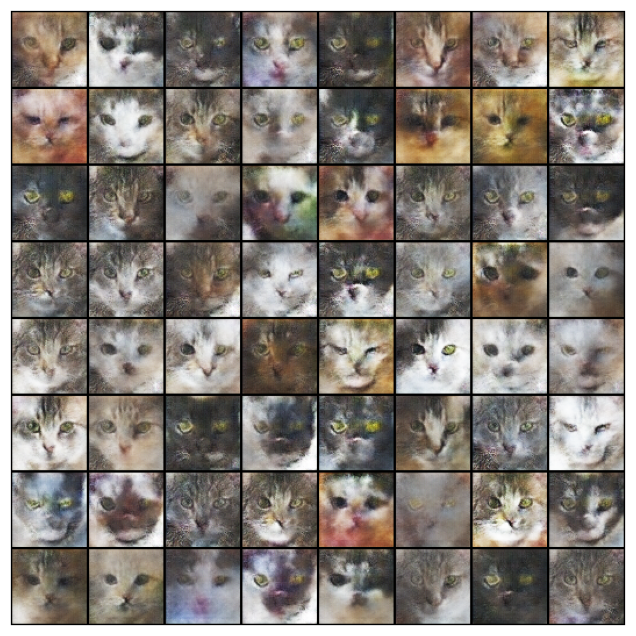

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

<h2>Wizualizacja wyników</h2>

Text(0.5, 1.0, 'Wartość funkcji straty dla dyskryminatora i generatora w poszczególnych epokach uczenia')

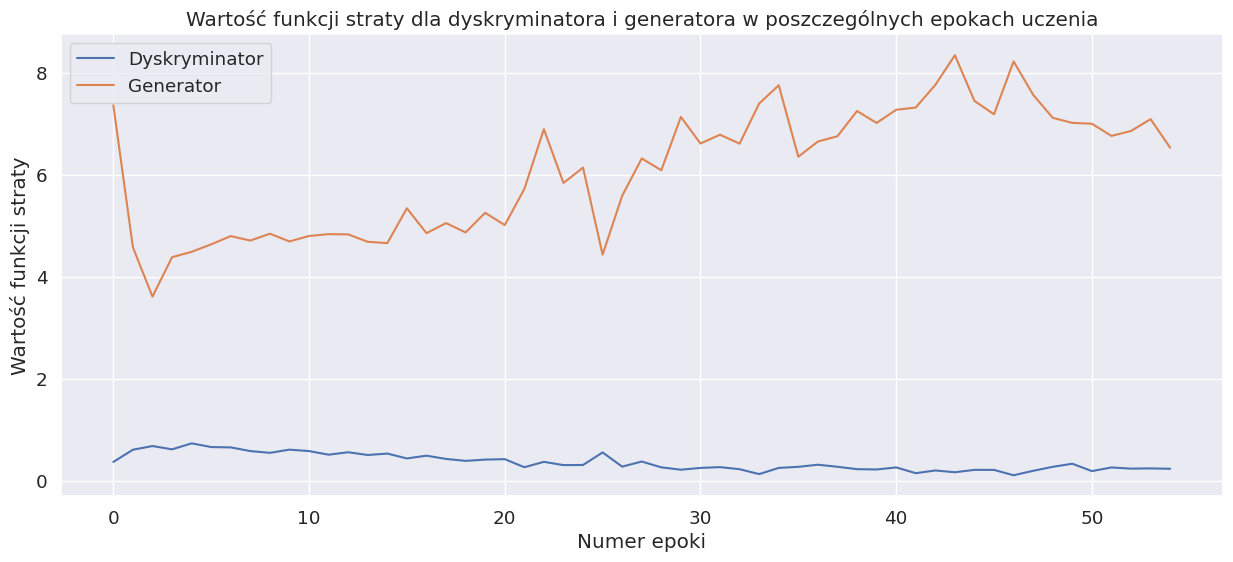

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('Numer epoki')
plt.ylabel('Wartość funkcji straty')
plt.legend(['Dyskryminator', 'Generator'])
plt.title('Wartość funkcji straty dla dyskryminatora i generatora w poszczególnych epokach uczenia')

Text(0.5, 1.0, 'Średnie wartości predykcji dla rzeczywistych i wygenerowanych obrazów')

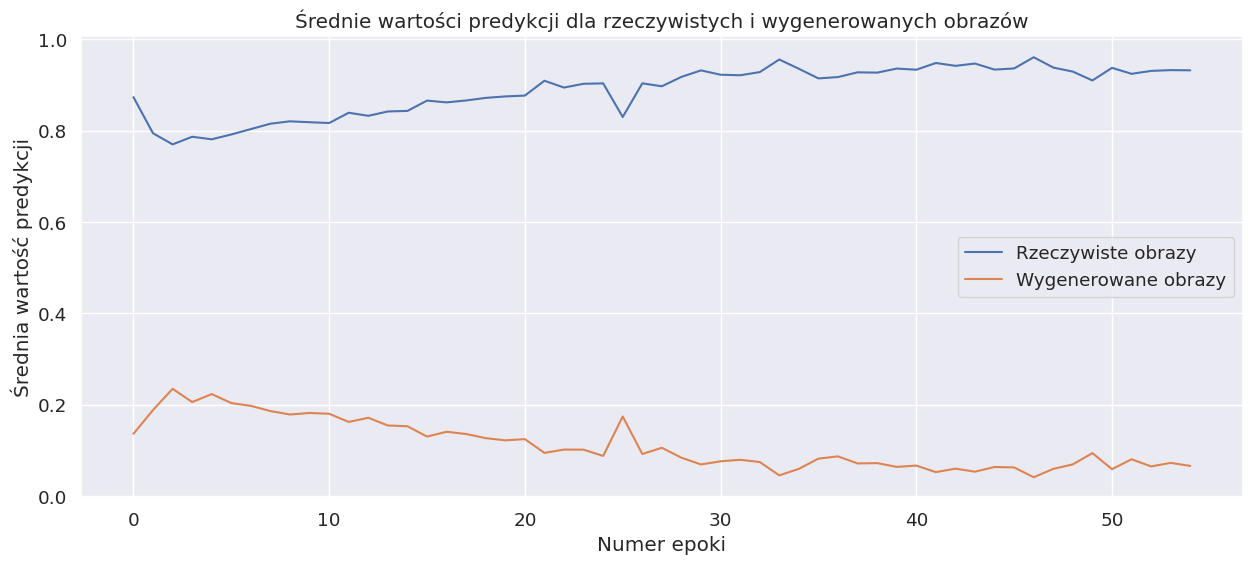

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('Numer epoki')
plt.ylabel('Średnia wartość predykcji')
plt.legend(['Rzeczywiste obrazy', 'Wygenerowane obrazy'])
plt.title('Średnie wartości predykcji dla rzeczywistych i wygenerowanych obrazów')